### Deep Deterministic Policy Gradient for Continuous Pendulum Control 

In [0]:
!pip install tqdm
import gym
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Input

COLAB = False
RESUME = False
path_base = "models/"
if COLAB:
    path_base = "drive/My Drive/"

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [0]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.size = buffer_size
        self.buffer = deque()
        
    def add(self, data_tuple):
        self.buffer.append(data_tuple)
        if len(self.buffer) > self.size:
            self.buffer.poplef()
            
    def sample(self, sample_size):
        return random.sample(self.buffer, min(len(self.buffer), sample_size))

# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [0]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.hidden_layers = params["actor_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.actor = self.model()
        
    def model(self):
        inputs = Input(shape=(1, self.state_dimensions))
        x = Lambda(lambda x: x)(inputs)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(self.action_dimensions, activation='tanh')(x)
        x = Lambda(lambda x: x*self.output_range)(x)
        model = tf.keras.Model(inputs = inputs, outputs = x)
        return model
    
    def get_action(self, state):
        return self.actor.predict(np.array([state]))[0][0]

        
    
class Critic:
    def __init__(self, params):
        self.hidden_layers = params["critic_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.critic_online = self.model()
        self.critic_target = self.model()


    def model(self):
        input_a = Input(shape = (1, self.state_dimensions))
        input_b = Input(shape = (1, self.action_dimensions))
        x = concatenate([input_a, input_b], axis=-1)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = tf.keras.Model(inputs=[input_a, input_b], outputs = x)
        model.compile(loss='mse', optimizer=self.optimizer)
        return model
    
    def save_weights(self):
        self.critic_online.save_weights(path_base + "critic_online.h5")
        self.critic_target.save_weights(path_base +  "critic_target.h5")
               
    def load_weights(self):
        self.critic_online.load_weights(path_base + "critic_online.h5")
        self.critic_target.load_weights(path_base + "critic_target.h5")

    def get_qvalues(self, state_tensor, action_tensor, online=True):
        return (self.critic_online([state_tensor, action_tensor]) if online else self.critic_target([state_tensor, action_tensor]))
    
    def merge_networks(self, tau):
        self.critic_target.set_weights(tau*np.array(self.critic_online.get_weights())
                                                                    + (1-tau)*np.array(self.critic_target.get_weights()))
        
    

In [0]:
class Agent:
    def __init__(self, params):
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayBuffer(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.tau = params["tau"]
        self.step = 0
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(params["action_dimensions"]))
        
    def agent_start(self, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        action = self.actor.get_action(observation) + self.noise_func()
        self.prev_state = observation
        self.prev_action = action
        return action 

    def agent_step(self, reward, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        relay = (self.prev_state, self.prev_action, reward, observation)
        self.buffer.add(relay)
        self.prev_state = observation
        self.prev_action = self.actor.get_action(observation) + self.noise_func()
        self.train(self.batch_size)

        return self.prev_action 
    
    def save_networks(self):
        self.actor.save_networks()
        self.critic.save_networks()


    def train(self, sample_size):
        self.step += 1
        batch = self.buffer.sample(sample_size)
        for prev_state, prev_action, reward, state in batch:
            state_action = np.array([self.actor.get_action(state)])
            action_tensor = tf.Variable(shape = (1, 1), initial_value = state_action)
            input_tensor = tf.Variable(shape=state.shape, initial_value = state)
            output = tf.squeeze(self.critic.get_qvalues(input_tensor, action_tensor, False)).numpy()
            output = reward + self.discount*output 

            self.critic.critic_online.fit([np.array([state]), np.array([state_action])], np.array([[output]]), verbose=0)

            prev_state_tensor = tf.Variable(shape=prev_state.shape, initial_value = prev_state)
            prev_action_tensor = tf.Variable(shape = (1, 1), initial_value = [prev_action])
            
            with tf.GradientTape(persistent=True) as g:
                g.watch(prev_action_tensor) 
                g.watch(prev_state_tensor)
                value = self.critic.get_qvalues(prev_state_tensor, prev_action_tensor)
                action = self.actor.actor(prev_state_tensor)
            
            gradient = tf.squeeze(g.gradient(value, prev_action_tensor)).numpy()
            gradient_actor = g.gradient(action, self.actor.actor.trainable_weights)
            gradient_actor = [-gradient*gradient for gradient in gradient_actor]
            
            self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))

        self.critic.merge_networks(self.tau)

        if self.step%self.save_frequency == 0:
            self.save_networks()



In [0]:
AGENT_PARAMS = {
	"output_range": 2,
	"actor_hidden_layers": [100, 50],
	"critic_hidden_layers": [100, 50],
	"state_dimensions": 3,
	"action_dimensions": 1,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"batch_size": 64,
	"buffer_size":1000000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 50
}
agent = Agent(AGENT_PARAMS)
env = gym.make('Pendulum-v0')


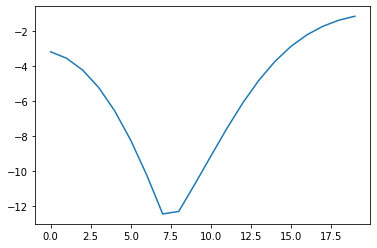

In [0]:
ITERATIONS = 4000
render = False
pbar = tqdm(desc="Game Step: ", total=ITERATIONS)

action = agent.agent_start(env.reset())
observation, reward, done, info = env.step(action)
rewards= []

for _ in range(ITERATIONS):
    action = agent.agent_step(reward, observation)
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    if render:
        env.render()
    pbar.update(1)

plt.plot(list(range(ITERATIONS)), rewards)
plt.show()
        
    